**This file converts maps highway density on census tracts**

**Author:** Eshan 

In [1]:
# Importing libraries
import geopandas as gpd
import os
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Construct the path to the shapefile using the os module
# The shapefile for census tracts is in data/nyc_ctracts_geo
# The shapefile is called nyct2020.shp
base_dir = os.getcwd()
shapefile_path = os.path.join(base_dir, '..', 'data', 'nyc_ctracts_geo', 'nyct2020.shp') # updated path

# Load the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Clean up the GeoDataFrame (remove gibberish rows manually inspected in the CSV)
# We filter out the rows that have gibberish in the 'BoroName' column
gdf = gdf[gdf['BoroName'].isin(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])]

# Ensure CTLabel and BoroCode are strings
gdf['CTLabel'] = gdf['CTLabel'].astype(str)
gdf['BoroCode'] = gdf['BoroCode'].astype(str)

# Print the columns
print(gdf.columns)

# Inspect the first few rows of the cleaned GeoDataFrame
print(gdf.head())

Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'PUMA',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')
  CTLabel BoroCode   BoroName  CT2020 BoroCT2020 CDEligibil  \
0       1        1  Manhattan  000100    1000100       None   
1    2.01        1  Manhattan  000201    1000201       None   
2       6        1  Manhattan  000600    1000600       None   
3   14.01        1  Manhattan  001401    1001401       None   
4   14.02        1  Manhattan  001402    1001402       None   

                                             NTAName NTA2020 CDTA2020  \
0  The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1                              Chinatown-Two Bridges  MN0301     MN03   
2                              Chinatown-Two Bridges  MN0301     MN03   
3                                    Lower East Side  MN0302     MN03   
4                                   

In [4]:
# Create the borough to county mapping dictionary
county_borough_mapping = {
    "Manhattan":"New York County",
    "Brooklyn": "Kings County",
    "Bronx":"Bronx County",
    "Staten Island":"Richmond County",
    "Queens":"Queens County" 
}

# BoroCode mapping
county_code_mapping = {
    "New York County": "061",
    "Kings County": "047",
    "Bronx County": "005",
    "Richmond County": "085",
    "Queens County": "081"
}

In [7]:
# Add a new column 'County' to the GeoDataFrame
gdf['County'] = gdf['BoroName'].map(county_borough_mapping)

# Add a new column 'CountyCode' to the GeoDataFrame
# Make sure the county code is three digits long - 61 should be 061
gdf['CountyCode'] = gdf['County'].map(county_code_mapping).str.zfill(3)

# Create a key using CountyCode and CT2020
gdf['key'] = gdf['CountyCode'] + gdf['CT2020']

# Print the first few rows of the GeoDataFrame
print(gdf.head())

  CTLabel BoroCode   BoroName  CT2020 BoroCT2020 CDEligibil  \
0       1        1  Manhattan  000100    1000100       None   
1    2.01        1  Manhattan  000201    1000201       None   
2       6        1  Manhattan  000600    1000600       None   
3   14.01        1  Manhattan  001401    1001401       None   
4   14.02        1  Manhattan  001402    1001402       None   

                                             NTAName NTA2020 CDTA2020  \
0  The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1                              Chinatown-Two Bridges  MN0301     MN03   
2                              Chinatown-Two Bridges  MN0301     MN03   
3                                    Lower East Side  MN0302     MN03   
4                                    Lower East Side  MN0302     MN03   

                                            CDTANAME        GEOID  PUMA  \
0  MN01 Financial District-Tribeca (CD 1 Equivalent)  36061000100  4121   
1   MN03 Lower East Side-Chinato

In [10]:
# Now we ingest the highway and roads data, create the same key and prepare to merge

# Construct the path to the tsv file using the os module
# The tsv file for highways is in data/roads/roads_highways.tsv
roads_highway_path = os.path.join(base_dir, '..', 'data', 'roads', 'roads_highways.tsv') # updated path

# Load the tsv file using pandas
df_highway = pd.read_csv(roads_highway_path, sep='\t')

# Ensure that the TRACT_FIPS20 column is treated as a string
df_highway['TRACT_FIPS20'] = df_highway['TRACT_FIPS20'].astype(str)

# Create 2 columns: state and key where state is the first 2 characters of column TRACT_FIPS20 and key is rest
df_highway['state'] = df_highway['TRACT_FIPS20'].str[:2]
df_highway['key'] = df_highway['TRACT_FIPS20'].str[2:]

# Filter for NY state which has code 36
df_highway = df_highway[df_highway['state'] == '36']

# Print the first few rows of the DataFrame
print(df_highway.head())

      TRACT_FIPS20  N_STREETS  SUM_STRINTLEN  N_PRIMARY_ROADS  \
49529  36001000100        242   30099.142578               48   
49530  36001000201        103   11961.093750                0   
49531  36001000202        211   23875.949219               12   
49532  36001000301         72   10345.257813                0   
49533  36001000302        476   61431.328125               82   

       N_SECONDARY_ROADS  N_PRIM_SEC_ROADS  PROP_PRIMARY_ROADS  \
49529                 26                74            0.198347   
49530                 29                29            0.000000   
49531                 50                62            0.056872   
49532                  6                 6            0.000000   
49533                 37               119            0.172269   

       PROP_SECONDARY_ROADS  PROP_PRIM_SEC_ROADS  SUM_STRLEN_PRIMARY  \
49529              0.107438             0.305785         7340.277832   
49530              0.281553             0.281553            0.000000

In [11]:
# Merging the GeoDataFrame and the DataFrame on key
merged_gdf = gdf.merge(df_highway, on='key', how='inner')

# Check the number of rows in the merged DataFrame
print(f"Number of rows in the merged DataFrame: {merged_gdf.shape[0]}")

# Inspect the first few keys of the merged DataFrame
print(merged_gdf['key'].head())

Number of rows in the merged DataFrame: 2321
0    061000201
1    061000600
2    061001401
3    061001402
4    061001800
Name: key, dtype: object


### Note on primary and secondary roads and streets

The research team used ArcGIS Desktop and the 2010/2020 TIGER/Line all lines (edges) shapefiles for all U.S. counties to identify edges that represented three types of roads: primary roads (limited-access highways with on- and off-ramps and are typically part of the interstate or state highway system), secondary roads (two or more lanes, intersect directly with other roads, and are generally part of a state or county road system), and all streets. Classification of roads as primary or secondary is based on the MAF/TIGER Feature Class Code (MTFCC), a five-character code used to classify features of the landscape and built environment (U.S. Census Bureau, 2016). The team then assigned roads to census tracts/ZIP code tabulation areas (ZCTA) using the TIGER/Line topological faces shapefile.

**Source:** https://www.icpsr.umich.edu/web/ICPSR/studies/38585

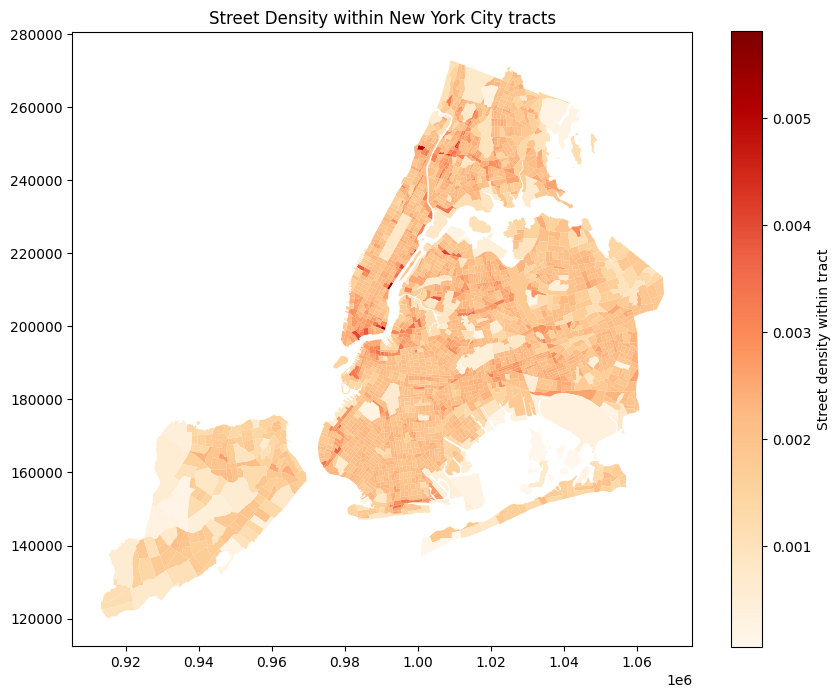

In [20]:
# First, let's plot the density of all streets in each census tract

merged_gdf['street_density'] = merged_gdf['SUM_STRINTLEN'] / merged_gdf['Shape_Area']

fig, ax = plt.subplots(1, 1, figsize=(10,8))
merged_gdf.plot(column='street_density', ax=ax, cmap='OrRd', \
    legend=True, legend_kwds={'label': "Street density within tract", 'orientation': "vertical"})
ax.set_title('Street Density within New York City tracts')
plt.show()

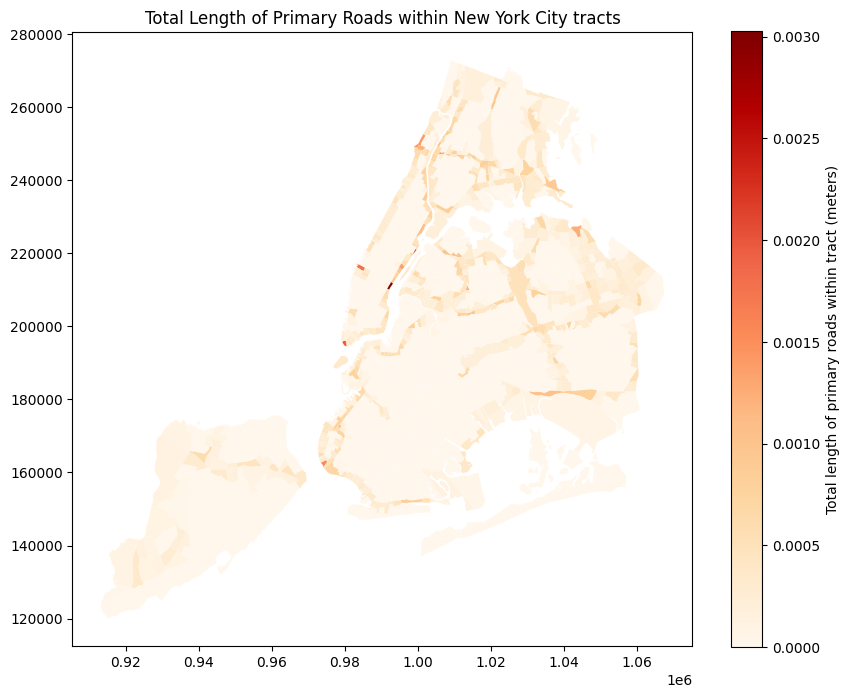

In [21]:
# Now, let's plot the sum of all PRIMARY streets (major highways) in each census tract

merged_gdf['primary_road_density'] = merged_gdf['SUM_STRLEN_PRIMARY'] / merged_gdf['Shape_Area']
fig, ax = plt.subplots(1, 1, figsize=(10,8))
merged_gdf.plot(column='primary_road_density', ax=ax, cmap='OrRd', \
    legend=True, legend_kwds={'label': "Total length of primary roads within tract (meters)", 'orientation': "vertical"})
ax.set_title('Total Length of Primary Roads within New York City tracts')
plt.show()

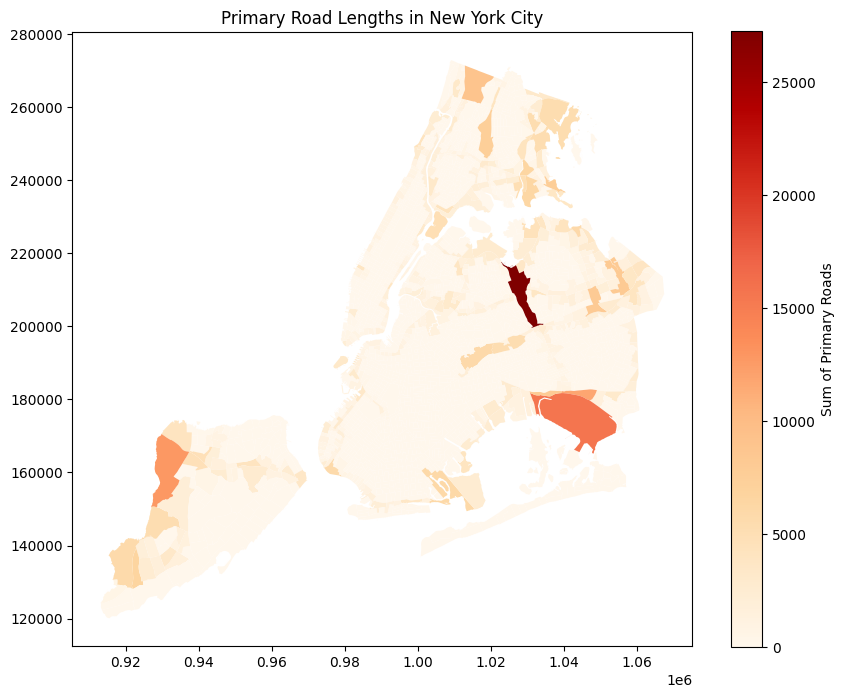

In [13]:
# Now, let's plot the sum of all SECONDARY streets in each census tract

street_sum_column = 'SUM_STRLEN_PRIMARY' 
fig, ax = plt.subplots(1, 1, figsize=(10,8))
merged_gdf.plot(column=street_sum_column, ax=ax, cmap='OrRd', \
    legend=True, legend_kwds={'label': "Total length of primary roads within tract (meters)", 'orientation': "vertical"})
ax.set_title('Total Length of Primary Roads within New York City tracts')
plt.show()